# In this file, the sensor data fetched by the Swing Metrics smartwatch app is parsed, cleaned and segmented to be fed to a neural network model. The intention is to classify tennis swing types (forehand, backhand) from it's associated accelerometer and gyroscope data.

In [1]:
# Imports.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, BatchNormalization, MaxPooling1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

sns.set(rc={'figure.figsize':(11.7, 8.27)})

In [2]:
# Use Pandas library to read csv files containing accelerometer and gyroscope data.

# Test batch for graphing.
test_forehands = pd.read_csv("data/test_forehands.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])
test_backhands = pd.read_csv("data/test_backhands.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])

# Usable samples.
fh_samples_batch_1 = pd.read_csv("data/fh_samples_1.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])
fh_samples_batch_2 = pd.read_csv("data/fh_samples_2.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])
bh_samples_batch_1 = pd.read_csv("data/bh_samples_1.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])
bh_samples_batch_2 = pd.read_csv("data/bh_samples_2.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])

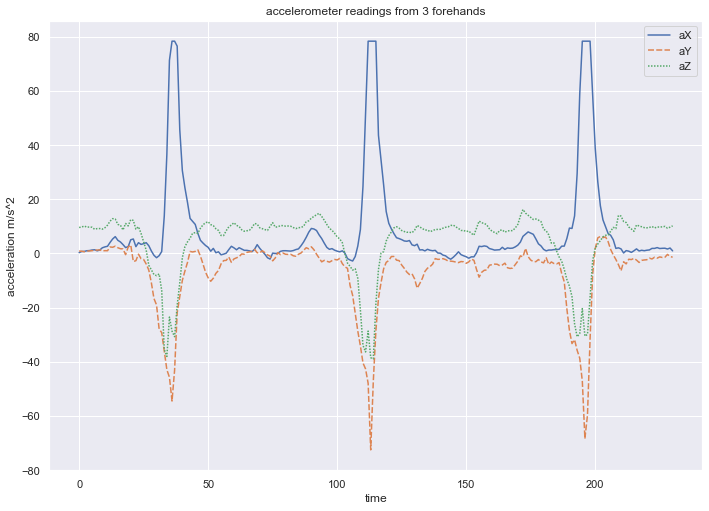

In [3]:
# Forehand accelerometer test readings.
accels = test_forehands["aX"], test_forehands["aY"], test_forehands["aZ"]
fig = sns.lineplot(data=accels)
fig.set(xlabel='time', ylabel='acceleration m/s^2', title='accelerometer readings from 3 forehands');

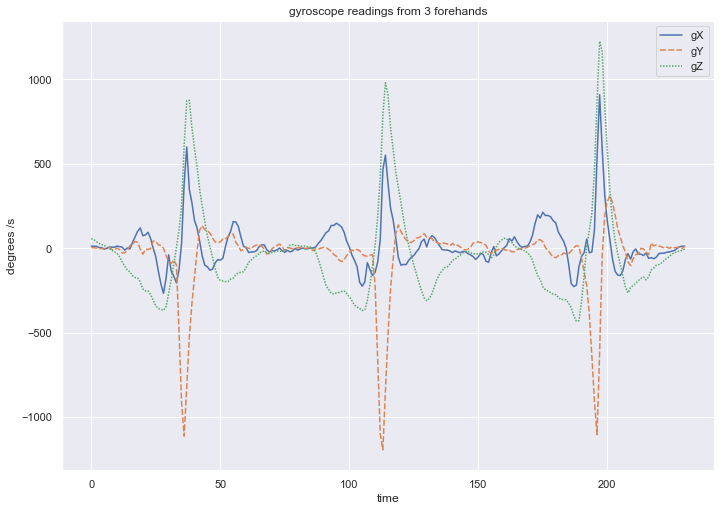

In [4]:
# Forehand gyroscope test readings.
gyros = test_forehands["gX"], test_forehands["gY"], test_forehands["gZ"]
fig = sns.lineplot(data=gyros)
fig.set(xlabel='time', ylabel='degrees /s', title='gyroscope readings from 3 forehands');

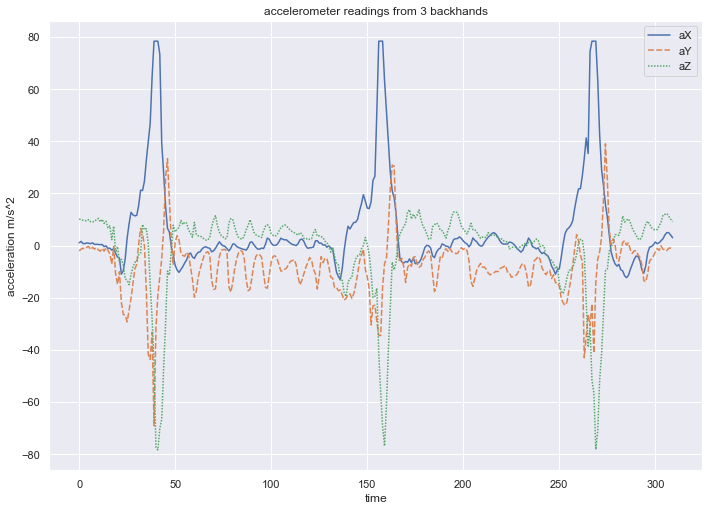

In [5]:
# Backhand accelerometer test readings.
accels = test_backhands["aX"], test_backhands["aY"], test_backhands["aZ"]
fig = sns.lineplot(data=accels)
fig.set(xlabel='time', ylabel='acceleration m/s^2', title='accelerometer readings from 3 backhands');

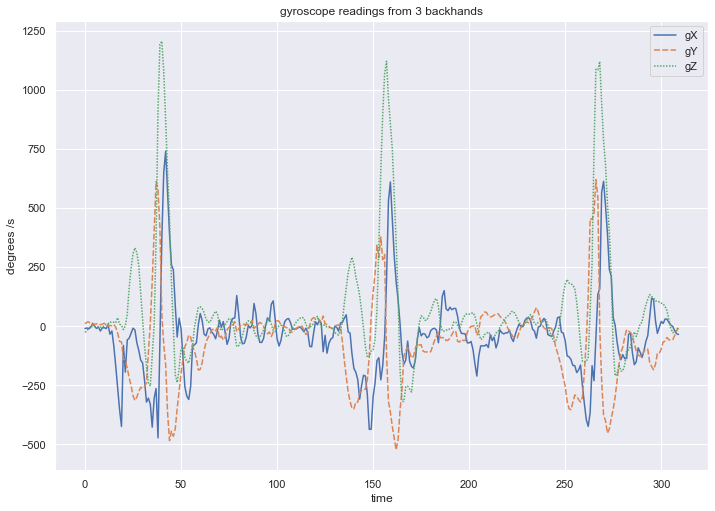

In [6]:
# Backhand gyroscope test readings
gyros = test_backhands["gX"], test_backhands["gY"], test_backhands["gZ"]
fig = sns.lineplot(data=gyros)
fig.set(xlabel='time', ylabel='degrees /s', title='gyroscope readings from 3 backhands');

In [7]:
# Identify a candidate swing event by detecting a spike in acceleration of 2g or higher.
# A threshhold of 2g has been selected, as is discussed in the following paper attempting
# to achieve the same task:
# https://core.ac.uk/download/pdf/147600847.pdf

def segment_samples(samples):
    # The timer can be dropped as the data is sequential.
    samples.drop(columns=["timer"], inplace=True)
    swing_samples = samples.to_numpy()
    
    peak_readings = []
    swings = []
    reading = 0
    last_seen = 0
    
    # For each reading (using the X reading), check if a peak has been identified.
    while reading < len(swing_samples):
        accel_val_x = swing_samples[reading, 0]
        if accel_val_x > 20 and accel_val_x < last_seen:
            # Log the peak.
            peak_readings.append(reading-1)
            
            # Isolate the candidate swing, testing has shown a 20 frame window either side of the peak is optimal.
            swing = []
            for i in range(reading-21, reading+19):
                swing.append(i)
            swings.append(swing)
            reading += 19
        last_seen = accel_val_x
        reading += 1
    
    # For each identified peak frame, append its X acceleration value.
    peaks = []
    for peak in peak_readings:
        peaks.append(swing_samples[peak][0]) 
    peaks = np.array(peaks)
    
    # For each group of frames representing a swing, generate a numpy array of the corresponding sensor 
    # data in model-feedable format.
    spliced_swings = []
    for swing_reading in range(len(swings)):
        spliced_swings.append(swing_samples[swings[swing_reading]])
    
    # Return the candidate swings and swing peaks.
    spliced_swings = np.array(spliced_swings)
    return peaks, spliced_swings

In [8]:
# Segment sample batches.

# Forehand batch 1.
peaks, fh_samples_batch_1 = segment_samples(fh_samples_batch_1)
# Forehands batch 2.
peaks, fh_samples_batch_2 = segment_samples(fh_samples_batch_2)

#Backhands batch 1.
peaks, bh_samples_batch_1 = segment_samples(bh_samples_batch_1)
#Backhands batch 2.
peaks, bh_samples_batch_2 = segment_samples(bh_samples_batch_2)

# Check resulting number of candidate swings.
print(fh_samples_batch_1.shape, fh_samples_batch_2.shape, bh_samples_batch_1.shape, bh_samples_batch_2.shape)

# Generate complete set of samples
complete_samples = np.concatenate((fh_samples_batch_1, fh_samples_batch_2, bh_samples_batch_1, bh_samples_batch_2))
print(complete_samples.shape)

(258, 40, 6) (116, 40, 6) (257, 40, 6) (101, 40, 6)
(732, 40, 6)


In [9]:
# Create a numpy array of labels corresponding to the swing types.
num_forehands = fh_samples_batch_1.shape[0] + fh_samples_batch_2.shape[0]
num_backhands = bh_samples_batch_1.shape[0] + bh_samples_batch_2.shape[0]

labels = []

# Binary labels.
forehand = 0
backhand = 1

for x in range(num_forehands):
    fh = []
    fh.append(forehand)
    labels.append(fh)
for y in range(num_backhands):
    bh = []
    bh.append(backhand)
    labels.append(bh)
    
y = np.array(labels)
y.shape

(732, 1)

In [10]:
# Split the samples into 75/25 train/test data, this ensures the model predicts on unseen data.
x_train, x_test, y_train, y_test = train_test_split(complete_samples, y)

In [11]:
# A swing consists of 40 frames with 6 features (3 accelerometer readings, 3 gyroscope readings).
num_timestamps = 40
num_features = 6

# Conv1D sequential model.
# This model is designed to follow a LeNet architecture. Consisting of 2 sets of convolutional layers,
# followed by max-pooling layers, before finally being passed through a fully-connected dense layer.
# Dropout layers switch nodes off at random as a means to prevent overfitting, which due to limitations 
# in my data collection is a concern. As such I follow up max-pooling layers with dropout.

# Initial leNet.
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_timestamps, num_features)))
model.add(MaxPooling1D(pool_size=(2)))
# Second leNet pattern.
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))
# Flatten and pass through a fully connected layer.
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# Compile and fit using the training data.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
18/18 [==============================] - 2s 93ms/step - loss: 45.6569 - accuracy: 0.7213 - val_loss: 1.0374 - val_accuracy: 0.9945
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 3.7489 - accuracy: 0.9552 - val_loss: 0.6285 - val_accuracy: 0.9945
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 1.9660 - accuracy: 0.9773 - val_loss: 0.0685 - val_accuracy: 0.9945
Epoch 4/30
18/18 [==============================] - 0s 9ms/step - loss: 1.6669 - accuracy: 0.9826 - val_loss: 8.1022e-11 - val_accuracy: 1.0000
Epoch 5/30
18/18 [==============================] - 0s 9ms/step - loss: 1.2418 - accuracy: 0.9936 - val_loss: 1.7007e-08 - val_accuracy: 1.0000
Epoch 6/30
18/18 [==============================] - 0s 9ms/step - loss: 0.7913 - accuracy: 0.9862 - val_loss: 2.1359e-37 - val_accuracy: 1.0000
Epoch 7/30
18/18 [==============================] - 0s 10ms/step - loss: 2.1366 - accuracy: 0.9875 - val_loss: 5.7846e-38 - val_accuracy: 1.0000


In [12]:
# Predict on the test set.
y_pred = model.predict(x_test)

# Print a classification report using the test values and predicted values.
target_names = ['forehand', 'backhand']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    forehand       1.00      1.00      1.00       105
    backhand       1.00      1.00      1.00        78

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183



In [13]:
# A test session where I hit 7 forehands and 4 backhands. 
# The demonstration section of my project will show this process in more detail!

# Create labels.
num_forehands = 7
num_backhands = 4
labels = []
for x in range(num_forehands):
    fh = []
    fh.append(forehand)
    labels.append(fh)
for y in range(num_backhands):
    bh = []
    bh.append(backhand)
    labels.append(bh) 
y_true = np.array(labels)

# Segment and predict on the unseen set.
unseen_set = pd.read_csv("data/unseen_set.csv", index_col=False, names=["timer", "aX", "aY", "aZ", "gX", "gY", "gZ"])
peaks, unseen_set = segment_samples(unseen_set)
y_pred = model.predict(unseen_set)
print(classification_report(y_true, y_pred, target_names=target_names))

# Both the test set and this unseen set show that for myself, the model can predict with 100% accuracy.
# Unfortunately due to Covid I was only able to gather data from myself and my parents which results in a
# naturally overfit model. I have attempted to reduce this by the use of dropout layers, and fully intend
# on gathering data from my local club once this is possible.

# While there are many datasets online pertaining to the quanity of a shot hit by professionals, these
# are achieved by the means of counting and I could not find an appropriate swing-sensor dataset online.

              precision    recall  f1-score   support

    forehand       1.00      1.00      1.00         7
    backhand       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

